# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [1]:
# In google collab, uncomment this:
!wget https://bit.ly/2FMJP5K -O setup.py && bash setup.py

# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

--2019-02-26 18:51:30--  https://bit.ly/2FMJP5K
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring19/setup_colab.sh [following]
--2019-02-26 18:51:30--  https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring19/setup_colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262 [text/plain]
Saving to: ‘setup.py’

setup.py            100%[===================>]     262  --.-KB/s    in 0s      

2019-02-26 18:51:31 (33.8 MB/s) - ‘setup.py’ saved [262/262]

Reading package lists... Done
Building dependency tree       
Reading state information.

In [2]:
import gym
import numpy as np
import pandas as pd

env = gym.make("Taxi-v2")
env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i" % (n_states, n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


In [0]:
policy = np.ones((n_states, n_actions))/n_actions

In [0]:
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1./n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

# Play the game

Just like before, but we also record all states and actions we took.

In [0]:
def generate_session_taxi(policy, t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.

    s = env.reset()

    for t in range(t_max):
        a = np.random.choice(n_actions, p=policy[s])

        new_s, r, done, info = env.step(a)

        # Record state, action and add up reward to states,actions and total_reward accordingly.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [0]:
s, a, r = generate_session_taxi(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float, np.float]

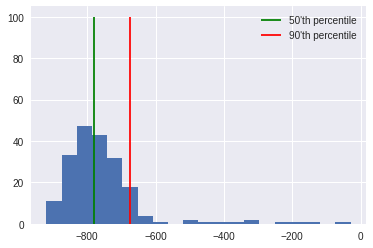

In [8]:
# let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session_taxi(policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [
           100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [
           100], label="90'th percentile", color='red')
plt.legend()

### Crossentropy method steps (2pts)

In [0]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)
   
    elite_states = []
    elite_actions = []
    
    for i in np.where(rewards_batch >= reward_threshold)[0]:
        elite_states.extend(states_batch[i])
        elite_actions.extend(actions_batch[i])
    
    return elite_states, elite_actions

In [10]:
states_batch = [
    [1, 2, 3],  # game1
    [4, 2, 0, 2],  # game2
    [3, 1]  # game3
]

actions_batch = [
    [0, 2, 4],  # game1
    [3, 2, 0, 1],  # game2
    [3, 3]  # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=0)
test_result_40 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
    and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
    "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
    np.all(test_result_40[1] == [3, 2, 0, 1, 3, 3]),\
    "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3, 1]) and \
    np.all(test_result_90[1] == [3, 3]),\
    "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3, 1]) and\
    np.all(test_result_100[1] == [3, 3]),\
    "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [0]:
def update_policy(elite_states, elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to

    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]

    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states, n_actions])

    for e in zip(elite_states, elite_actions):
        new_policy[e] += 1
    
    es = np.unique(elite_states)
    
    non_es = np.arange(n_states)
    non_es = non_es[~np.isin(non_es, es)]
    
    new_policy[es] = new_policy[es]/new_policy[es].sum(axis=1).reshape(len(es), 1)
    new_policy[non_es] = 1/n_actions
    
    # Don't forget to set 1/n_actions for all actions in unvisited states.

    return new_policy

In [12]:
elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1],
                               [0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states, elite_actions)

assert np.isfinite(new_policy).all(
), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(
    new_policy >= 0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(
    axis=-1), 1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
    [1.,  0.,  0.,  0.,  0.],
    [0.5,  0.,  0.,  0.5,  0.],
    [0.,  0.33333333,  0.66666667,  0.,  0.],
    [0.,  0.,  0.,  0.5,  0.5]])
assert np.allclose(new_policy[:4, :5], reference_answer)
print("Ok!")

Ok!


# Training loop
Generate sessions, select N best and fit to those.

In [0]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [0]:
def train(
    n_sessions=250, # sample this many sessions
    percentile=50, # take this percent of session with highest rewards
    learning_rate=0.5, # add this thing to all counts for stability
    percentile_func=None
):
    global env
    env = gym.make("Taxi-v2")
    env.reset()
  
    global n_states
    global n_actions
    
    n_states = env.observation_space.n
    n_actions = env.action_space.n
  
    # reset policy just in case
    policy = np.ones([n_states, n_actions])/n_actions

    log = []

    for i in range(100):
  
        current_percentile = percentile_func(i) if percentile_func else percentile
      
        sessions = [generate_session_taxi(policy) for x in range(n_sessions)]

        states_batch, actions_batch, rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, current_percentile)

        new_policy = update_policy(elite_states, elite_actions)

        policy = learning_rate*new_policy + (1-learning_rate)*policy

        # display results on chart
        show_progress(rewards_batch, log, current_percentile)
        print(i, current_percentile)

mean reward = -49.268, threshold=6.000


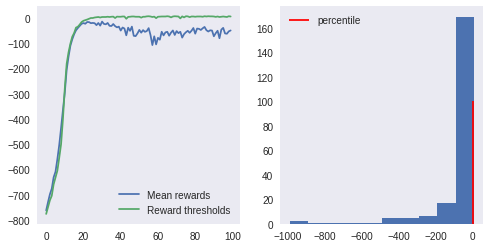

99 50


In [0]:
train()

# Digging deeper: approximate crossentropy with neural nets

![img](https://casd35.wikispaces.com/file/view/digging_deeper_final.jpg/359658499/503x260/digging_deeper_final.jpg)

In this section we will train a neural network policy for continuous state space game

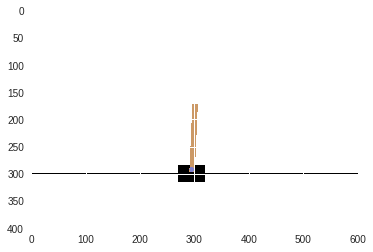

In [15]:
# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"))

In [0]:
# create agent
from sklearn.neural_network import MLPClassifier

def create_agent(hidden_layers=(20, 20), learning_rate=0.001):
    agent = MLPClassifier(hidden_layer_sizes=hidden_layers,
                          learning_rate_init=learning_rate,
                          activation='tanh',
                          warm_start=True,  # keep progress between .fit(...) calls
                          max_iter=1  # make only 1 iteration on each .fit(...)
                          )
    # initialize agent to the dimension of state an amount of actions
    agent.fit([env.reset()]*n_actions, range(n_actions))
    return agent

In [0]:
def generate_session(agent, t_max=1000, env_name=None):

    states, actions = [], []
    total_reward = 0

    if env_name is None:
        global env
        s = env.reset()
    else:
        env = gym.make(env_name).env
        s = env.reset()

    for t in range(t_max):

        # predict array of action probabilities
        probs = agent.predict_proba([s])[0]

        a = np.random.choice(n_actions, p=probs)

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [0]:
def train_with_agent(agent, n_sessions=100, percentile=70, n_iter=100, t_max=1000, success=190, break_on_success=False, reward_range=None, percentile_func=None, env_name='CartPole-v0', n_jobs=1):
    log = []
    times = [0]*n_iter
    for i in range(n_iter):
        t = time.time()
        current_percentile = percentile_func(i) if percentile_func else percentile
        
        if n_jobs > 1:
            sessions = Parallel(n_jobs=n_jobs)(delayed(lambda: generate_session(agent, t_max, env_name))() for x in range(n_sessions))
        else:
            # generate new sessions
            sessions = [generate_session(agent, t_max) for x in range(n_sessions)]

        states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, current_percentile)

        agent.fit(elite_states, elite_actions)
        # <fit agent to predict elite_actions(y) from elite_states(X) >

        show_progress(rewards_batch, log, current_percentile, reward_range=reward_range if reward_range else [0, np.max(rewards_batch)])

        if np.mean(rewards_batch) > success:
            print("You Win! You may stop training now via KeyboardInterrupt.")
            if break_on_success:
                break
        times[i] = time.time() - t
    return times

mean reward = 190.100, threshold=200.000


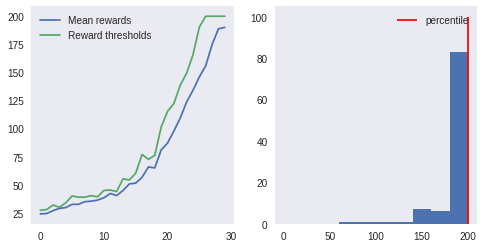

You Win! You may stop training now via KeyboardInterrupt.


In [0]:
agent = create_agent()
train_with_agent(agent, n_iter=30)

# Results

In [0]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session(agent) for _ in range(100)]
env.close()


In [0]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

In [0]:
!zip -r ./vids.zip ./videos/

from google.colab import files
files.download("./vids.zip")

  adding: videos/ (stored 0%)
  adding: videos/openaigym.video.2.155.video000000.mp4 (deflated 17%)
  adding: videos/openaigym.video.2.155.video000008.meta.json (deflated 60%)
  adding: videos/openaigym.episode_batch.1.155.stats.json (deflated 77%)
  adding: videos/openaigym.video.2.155.video000001.meta.json (deflated 60%)
  adding: videos/openaigym.video.2.155.video000064.mp4 (deflated 16%)
  adding: videos/openaigym.video.1.155.video003000.meta.json (deflated 60%)
  adding: videos/openaigym.manifest.1.155.manifest.json (deflated 83%)
  adding: videos/openaigym.video.2.155.video000001.mp4 (deflated 21%)
  adding: videos/openaigym.episode_batch.2.155.stats.json (deflated 80%)
  adding: videos/openaigym.video.2.155.video000027.mp4 (deflated 17%)
  adding: videos/openaigym.video.2.155.video000064.meta.json (deflated 60%)
  adding: videos/openaigym.video.2.155.video000008.mp4 (deflated 19%)
  adding: videos/openaigym.video.2.155.video000000.meta.json (deflated 60%)
  adding: videos/openai

# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples.
- __1.2__ (2 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


#### 1.1 (1 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples.

mean reward = -0.752, threshold=-0.750


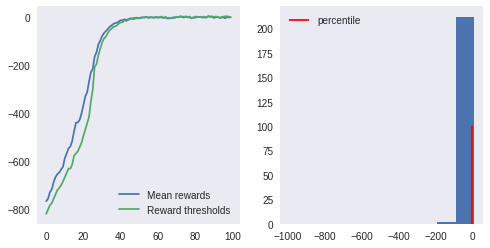

In [0]:
train(percentile=25)

Видно, что алгоритм ведет себя лучше при уменьшении percentile, но сходится медленнее. Такое поведение возможно из-за того, что в начале создается много "мусорных" сессий и при выборе маленького перцентиля мы их не отбрасываем.

mean reward = -392.736, threshold=6.000


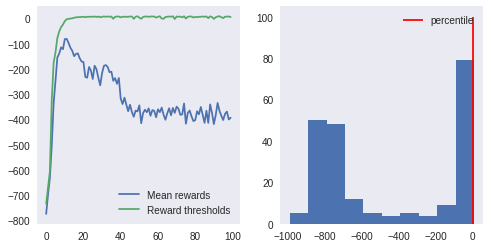

In [0]:
train(percentile=75)

По графику видно, что при увеличении percentile алгоритм быстрее сходится к значению -100, но дальше алгоритм не обучается, возможно, из-за того, что мы рассматриваем только самые успешные сессии и не смотрим на сессии с какими-то нетипичными событиями (после продолжительного обучения "мусорных" сессий генерится меньше, поэтому уменьшение перцентиля может помочь обучению)

mean reward = -148.856, threshold=-16.000


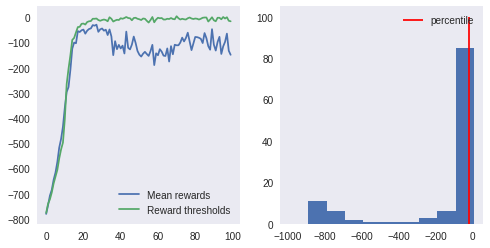

In [0]:
train(n_sessions=125)

mean reward = -39.742, threshold=8.000


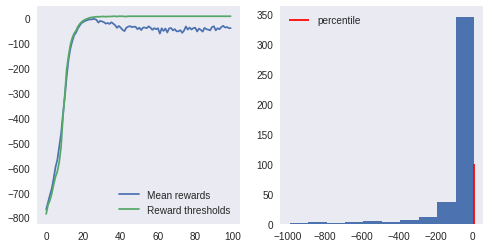

In [0]:
train(n_sessions=500)

mean reward = -1.888, threshold=6.000


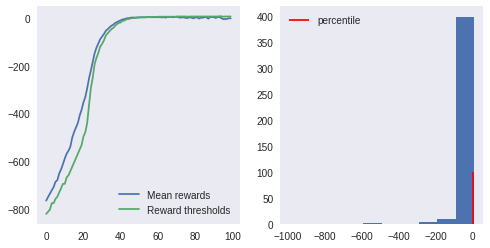

In [0]:
train(n_sessions=500, percentile=25)

mean reward = -249.872, threshold=9.000


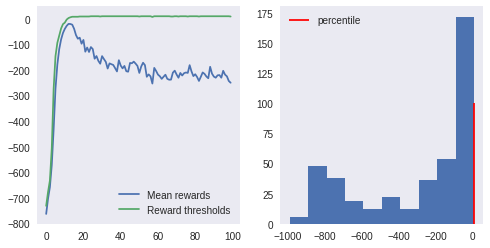

In [0]:
train(n_sessions=500, percentile=75)

mean reward = -30.968, threshold=-25.000


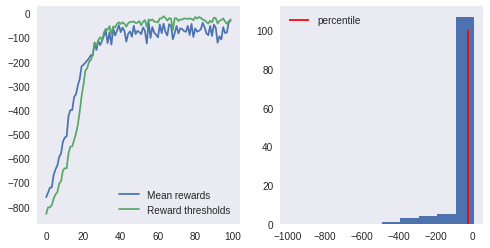

In [0]:
train(n_sessions=125, percentile=25)

mean reward = -499.816, threshold=-22.000


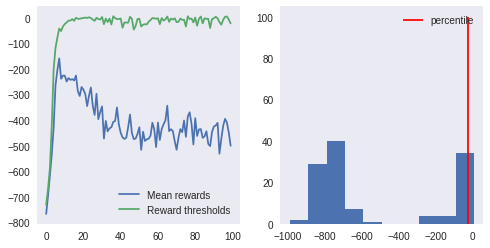

In [0]:
train(n_sessions=125, percentile=75)

По графикам видно, что при увеличении количества сессий, обучение происходит намного стабильнее. Также можно заметить, что графики для `n_sessions=250` (исходный график) и `n_sessions=500` не сильно отличаются друг от друга, поэтому можно сделать вывод, что `n_sessions=250` будет достаточно

#### 1.2 (2 pts) Tune the algorithm to end up with positive average score.

Из графиков выше видно, что n_sessions можно оставить без изменения (250). Также понятно, что в начале обучения имеет смысл установить больший перцентиль, а в конце обучения - меньший. Исходя из этого, начал передавать в функцию `train` функцию, которая в зависимости от итерации возвращает перцентиль от 50 в начале до 5 в конце обучения.

mean reward = 3.780, threshold=-12.000


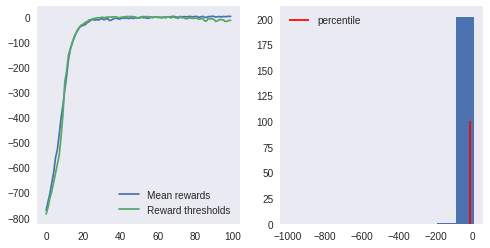

99 5.450000000000003


In [0]:
percentile_start = 50
percentile_end = 5

train(percentile_func=lambda i: percentile_start - i/100*(percentile_start - percentile_end))

# Homework part II

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (bonus: 4++ pt) Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  * __Please list what you did in anytask submission form__
  
  
### Tips
* Gym page: [mountaincar](https://gym.openai.com/envs/MountainCar-v0), [lunarlander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

### Bonus tasks

* __2.3 bonus__ Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in anytask submission._)

* __2.4 bonus__ Solve continuous action space task with `MLPRegressor` or similar.
  * Start with ["Pendulum-v0"](https://github.com/openai/gym/wiki/Pendulum-v0).
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) 
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules aside from action spaces.


If you're still feeling unchallenged, consider the project (see other notebook in this folder).

#### 2.1 (3 pts) For LunarLander, get average reward of at least +50

In [19]:
!pip install box2d-py

In [0]:
import matplotlib.pyplot as plt

%matplotlib inline

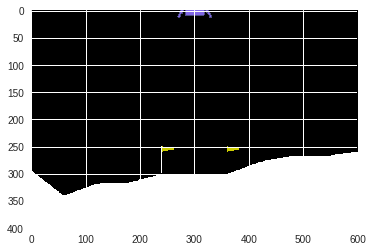

In [21]:
env = gym.make("LunarLander-v2")
env.reset()
plt.imshow(env.render('rgb_array'))

n_actions = env.action_space.n

Попробуем запустить без изменения агента и параметров метода train

mean reward = 37.574, threshold=50.796


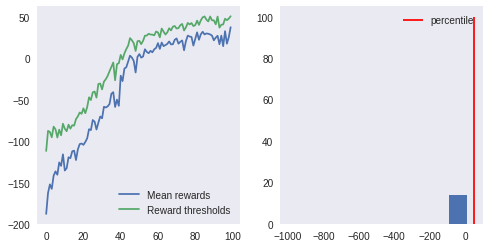

In [0]:
agent = create_agent()
train_with_agent(agent, reward_range=[-990, +10])

Попробуем теперь, как в предыдущем пункте, задавать перцентиль в зависимости от итерации

mean reward = 10.641, threshold=4.884


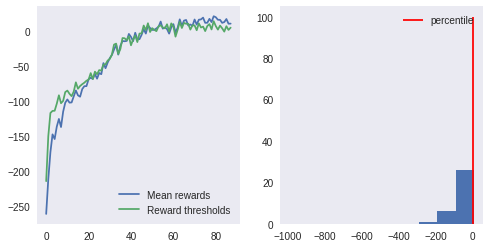

KeyboardInterrupt: ignored

In [0]:
agent = create_agent()
percentile_start = 60
percentile_end = 20
train_with_agent(agent, reward_range=[-990, +10], success=50, break_on_success=True,
                 percentile_func=lambda i: percentile_start - i/100*(percentile_start - percentile_end))

Попробуем усложнить нейросеть агента

mean reward = 65.718, threshold=121.444


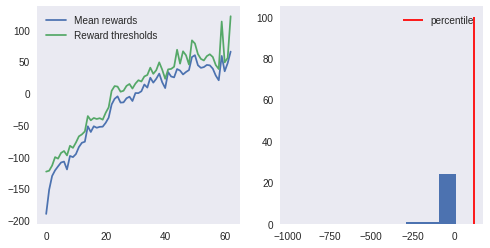

KeyboardInterrupt: ignored

In [0]:
agent = create_agent(hidden_layers=(64, 128, 64))
train_with_agent(agent, reward_range=[-990, +10])

С усложненной нейросетью смогли получить mean_reward > 50

In [0]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("LunarLander-v2"),
                           directory="videos_lander", force=True)
sessions = [generate_session(agent) for _ in range(100)]
env.close()

In [0]:
!zip -r ./vids.zip ./videos_lander/

from google.colab import files
files.download("./vids.zip")

  adding: videos_lander/ (stored 0%)
  adding: videos_lander/openaigym.video.3.155.video000008.meta.json (deflated 60%)
  adding: videos_lander/openaigym.manifest.3.155.manifest.json (deflated 70%)
  adding: videos_lander/openaigym.video.3.155.video000000.meta.json (deflated 60%)
  adding: videos_lander/openaigym.video.3.155.video000008.mp4 (deflated 8%)
  adding: videos_lander/openaigym.episode_batch.3.155.stats.json (deflated 62%)
  adding: videos_lander/openaigym.video.3.155.video000064.mp4 (deflated 16%)
  adding: videos_lander/openaigym.video.3.155.video000027.mp4 (deflated 13%)
  adding: videos_lander/openaigym.video.3.155.video000027.meta.json (deflated 60%)
  adding: videos_lander/openaigym.video.3.155.video000000.mp4 (deflated 16%)
  adding: videos_lander/openaigym.video.3.155.video000001.meta.json (deflated 60%)
  adding: videos_lander/openaigym.video.3.155.video000064.meta.json (deflated 60%)
  adding: videos_lander/openaigym.video.3.155.video000001.mp4 (deflated 8%)


#### 2.2 (bonus: 4++ pt) Devise a way to speed up training at least 2x against the default version (Obvious improvement: use joblib)

Теперь попробуем ускорить генерацию сессий с помощью joblib

In [22]:
!pip install joblib

In [0]:
from joblib import Parallel, delayed
import time

mean reward = -17.861, threshold=4.081


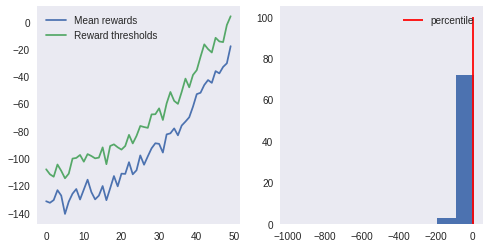

In [0]:
times1 = train_with_agent(create_agent(), reward_range=[-990, +10], n_iter=50)

mean reward = -12.265, threshold=10.255


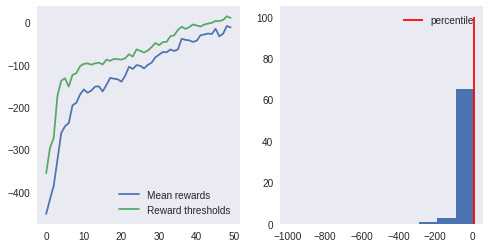

In [0]:
times2 = train_with_agent(create_agent(), reward_range=[-990, +10], n_iter=50, env_name='LunarLander-v2', n_jobs=8)

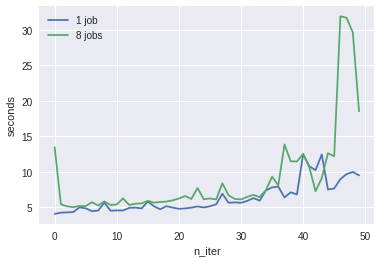

In [0]:
a = np.arange(50)
plt.xlabel('n_iter')
plt.ylabel('seconds')
plt.plot(a, times1, label='1 job')
plt.plot(a, times2, label='8 jobs')
plt.legend()
plt.show()

In [0]:
sum(times1)

314.6758418083191

In [0]:
sum(times2)

447.91538429260254

[Говорят](https://stackoverflow.com/a/51664404/4631928), что в колабе одно ядро доступно, этим можно объяснить замедление с использованием нескольких потоков

mean reward = -13.488, threshold=11.969


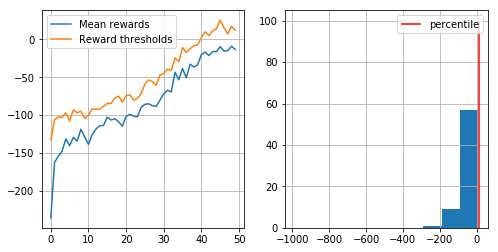

In [0]:
times1 = train_with_agent(create_agent(), reward_range=[-990, +10], n_iter=50)

mean reward = -45.992, threshold=-8.601


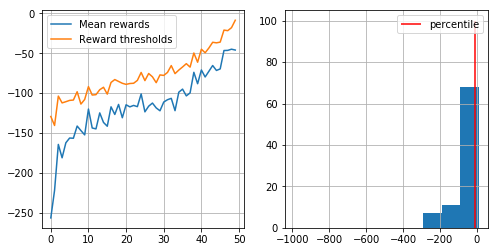

In [0]:
times2 = train_with_agent(create_agent(), reward_range=[-990, +10], n_iter=50, env_name='LunarLander-v2', n_jobs=8)

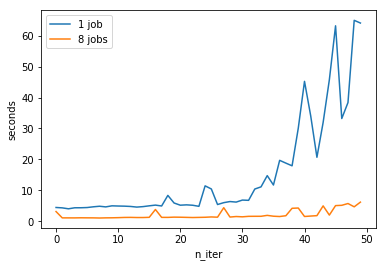

In [0]:
a = np.arange(50)
plt.xlabel('n_iter')
plt.ylabel('seconds')
plt.plot(a, times1, label='1 job')
plt.plot(a, times2, label='8 jobs')
plt.legend()
plt.show()

In [0]:
sum(times1)

755.8800921440125

In [0]:
sum(times2)

106.88934063911438

На i7-6700 удалось ускорить в 8 раз при использовании 8 потоков по сравнению с одним.